In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import IterativeStratification
from pathlib import Path
from typing import Tuple
from tqdm.notebook import tqdm
import json
import numpy as np

In [2]:
def load_dataset(
    data_path: Path,
    labels_file: str = 'labels.json'
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    annotations_path = data_path / labels_file

    with open(annotations_path, "r") as f:
        targets_json = json.load(f)
    id2label = {cat['id']:cat['name'] for cat in targets_json['categories']}
    images_df = pd.DataFrame.from_records(targets_json["images"])
    images_df.rename(columns={"id": "image_id"}, inplace=True)
    images_df = images_df[["image_id", "file_name"]]

    targets_df = pd.DataFrame.from_records(targets_json["annotations"])
    
    targets_df[["xmin", "ymin", "w", "h"]] = targets_df["bbox"].tolist()
    targets_df["xmax"] = targets_df["xmin"] + targets_df["w"]
    targets_df["ymax"] = targets_df["ymin"] + targets_df["h"]
    targets_df.reset_index(inplace=True)
    targets_df['index'] = targets_df['id']
    targets_df.rename(
        columns={"index": "target_id", "category_id": "label_id"}, inplace=True
    )
    targets_df = targets_df[
        ["target_id", "image_id", "label_id", "xmin", "ymin", "xmax", "ymax"]
    ]
    
    return images_df, targets_df, id2label

In [39]:
df_path = Path('./dataset')
images_df, targets_df, id2label = load_dataset(df_path)

In [7]:
checked_labels = pd.read_pickle('checked_samples.pkl')

In [28]:
TP = checked_labels['TP'].sum()
TN = checked_labels['TN'].sum()
FP = checked_labels['FP'].sum()
FN = checked_labels['FN'].sum()
confusion_matrix = np.array([[TN, FP],
                             [FN, TP]])

In [35]:
checked_labels.query('TP==0').shape

(42, 7)

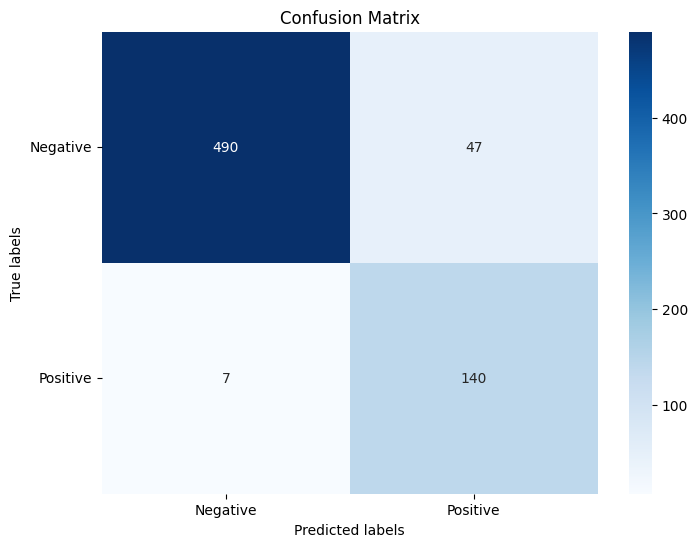

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

# Добавление подписей
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'], rotation=0)

# Показать график
plt.show()

In [29]:
precision = TP / (TP+FP)
precision

0.7486631016042781

In [30]:
recall = TP / (TP+FN)
recall

0.9523809523809523

In [31]:
fpr = FP / (FP + TN)
fpr

0.08752327746741155

In [5]:
sets = []
for split in tqdm(range(1,6)):
    with open(f'dataset/yolo_test_{split}.txt', 'r') as f:
        gar = f.readlines()
    imgs = []
    for img in gar:
        imgs.append(img[9:-1])
    sets.append(set(imgs))

  0%|          | 0/5 [00:00<?, ?it/s]

In [62]:
checked_labels.describe().to_excel('cf_mat.xlsx')

In [6]:
from tqdm.notebook import tqdm
df_count = pd.DataFrame(columns=[i+1 for i in range(11)])
for split in tqdm(range(1,6)):
    with open(f'dataset/yolo_test_{split}.txt', 'r') as f:
        gar = f.readlines()
    imgs = []
    for img in gar:
        imgs.append(img[9:-1])
   
    label_count = {}
    for i in range(11):
        label_count[i+1] = 0
    for img in tqdm(imgs):
        id = images_df.query('file_name==@img')['image_id'].values[0]
        counted = targets_df.query('image_id==@id')['label_id'].value_counts().to_dict()
        for label in counted:
            label_count[label] += counted[label]
    label_count['split'] = split
   
    df_count.loc[len(df_count)] = label_count
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5971 [00:00<?, ?it/s]

  0%|          | 0/5954 [00:00<?, ?it/s]

  0%|          | 0/5956 [00:00<?, ?it/s]

  0%|          | 0/5958 [00:00<?, ?it/s]

  0%|          | 0/5961 [00:00<?, ?it/s]

In [20]:
df_count['summ'] = df_count.sum(axis=1)

In [62]:
def mrat(series):
    total = [38628, 38986, 39106, 39090, 38729]
    ratios = []
    for i, elem in enumerate(series):
        ratios.append(elem/total[i])
    return sum(ratios)/len(ratios)

In [12]:
label_count = {}
for i in range(11):
    label_count[i+1] = 0
for label in label_count:
    label_count[label] = len(targets_df.query('label_id==@label'))

In [61]:
word_tbl = df_count[[2, 3, 7, 5, 11, 4, 1, 8, 6, 9, 10, 'summ']].T
orig = sorted(list(label_count.values()), reverse=True)
orig.append(sum(orig))
word_tbl['orig'] = orig
word_tbl = word_tbl[['orig', 0, 1, 2, 3, 4]]
word_tbl['ratio'] = word_tbl['orig'].apply(lambda x: x/194539)
word_tbl['mean_ratio'] = word_tbl[[0,1,2,3,4]].apply(lambda x: mrat(x), axis=1)

5
5
5
5
5
5
5
5
5
5
5
5


In [66]:
word_tbl.to_excel('ratio_tbl.xlsx')

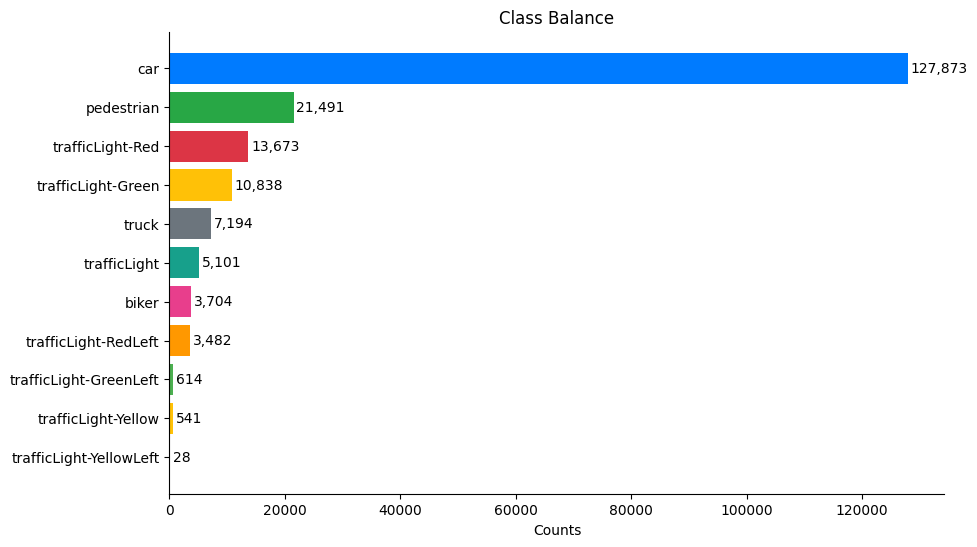

In [31]:
import matplotlib.pyplot as plt
import numpy as np


classes = [
    "car", "pedestrian", "trafficLight-Red", "trafficLight-Green", "truck",
    "trafficLight", "biker", "trafficLight-RedLeft", "trafficLight-GreenLeft",
    "trafficLight-Yellow", "trafficLight-YellowLeft"
]
counts = sorted(list(label_count.values()), reverse=True)
status = [
    "over represented", "under represented", "under represented", "under represented",
    "under represented", "under represented", "under represented", "under represented",
    "under represented", "under represented", "under represented"
]


colors = ['#007bff', '#28a745', '#dc3545', '#ffc107', '#6c757d', '#17a08b', '#e83e8c', 
          '#ff9800', '#4caf50', '#ffc107', '#bdbdbd']


fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(classes, counts, color=colors)


for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 500  
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:,}', va='center')


ax.set_xlabel('Counts')
ax.set_title('Class Balance')
ax.invert_yaxis()  
ax.set_yticks(np.arange(len(classes)))
ax.set_yticklabels(classes)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


In [78]:
with open('dataset/labels.json', 'r') as f:
    coco_data = json.load(f)
for split in tqdm(range(1,6)):
    with open(f'dataset/yolo_test_{split}.txt', 'r') as f:
        subset_files = [line.strip().replace('./images/', '').replace('.txt', '') for line in f]
    subset_files_set = set(subset_files)
    filtered_images = [image for image in coco_data['images'] if image['file_name'] in subset_files_set]
    filtered_image_ids = set(image['id'] for image in filtered_images)
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in filtered_image_ids]
    new_coco_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': coco_data['categories']  
    }
    with open(f'dataset/labels_{split}.json', 'w') as f:
        json.dump(new_coco_data, f, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
imgs_check = pd.DataFrame(columns=['image_id', 'file_name', 'split'])
for split in tqdm(range(1,6)):
    images_df, targets_df, id2label = load_dataset(df_path, f'labels_{split}.json')
    imgs_choice = images_df.sample(n=20, random_state=42)
    imgs_choice['split'] = split
    imgs_check = pd.concat([imgs_check, imgs_choice], axis='rows', ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
# imgs_check['TP'] = 0
# imgs_check['TN'] = 0
# imgs_check['FP'] = 0
# imgs_check['FN'] = 0

In [301]:
# num = 100
# print(imgs_check.iloc[num]['file_name'])
# imgs_check.loc[num, 'TP'] = 0
# imgs_check.loc[num, 'TN'] = 0
# imgs_check.loc[num, 'FP'] = 0
# imgs_check.loc[num, 'FN'] = 0
# imgs_check.iloc[num]

In [303]:
#imgs_check.to_pickle('checked_samples.pkl')

In [3]:
all_pred = pd.DataFrame()
for split in range(1,6):
    test = pd.read_pickle(f'predictions/preds_labels_{split}.json.pkl')
    all_pred = pd.concat([all_pred, test], axis='rows', ignore_index=True)
all_pred.to_pickle('all_pred.pkl')

In [4]:
df_path = Path('./dataset')
images_df, targets_df, id2label = load_dataset(df_path)

In [8]:
labels = []
predictions = []
for index, row in tqdm(checked_labels.iterrows(), total=len(checked_labels)):
    img_id = row['image_id']
    label = {
        'bboxes': targets_df.query('image_id==@img_id')[['xmin', 'ymin', 'xmax','ymax']].to_numpy(dtype='float32'),
        'labels': targets_df.query('image_id==@img_id')['label_id'].to_numpy(dtype='float32')-1
            }
    pred = []
    preds = all_pred.query('image_id==@img_id')
    for class_id in range(1, 12):
        pred.append(preds.query('label_id==@class_id')[['xmin', 'ymin', 'xmax','ymax', 'score']].to_numpy(dtype='float32'))
    #pred = np.array(pred, dtype='float32')
    labels.append(label)
    predictions.append(pred)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
from cleanlab.object_detection.filter import find_label_issues
from cleanlab.object_detection.rank import get_label_quality_scores

In [72]:
# import pickle

# with open('predictions.pkl', 'wb') as fp:
#     pickle.dump(predictions, fp)
# with open('labels.pkl', 'wb') as fp:
#     pickle.dump(labels, fp)

In [73]:
# with open('predictions.pkl', 'rb') as f:
#     a = pickle.load(f)
# with open('labels.pkl', 'rb') as f:
#     b = pickle.load(f)

In [12]:
has_label_issue = find_label_issues(labels, predictions, return_indices_ranked_by_score=True)

Pruning 0 predictions out of 189 using threshold==0.0. These predictions are no longer considered as potential candidates for identifying label issues as their similarity with the given labels is no longer considered.


In [15]:
has_label_issue

array([54,  5, 22, 62, 47, 57, 11, 83, 29, 19, 36, 12, 97, 91, 25, 38, 55,
       74, 34], dtype=int64)

In [27]:
sum(checked_labels.iloc[has_label_issue]['TP']==0)

4